In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, Dense, Conv2D, Conv2DTranspose, BatchNormalization, Dense, Dropout, Flatten, Reshape, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# 이미지 입력 차원
img_shape = (img_rows, img_cols, channels)

# 잡음 벡터의 크기
z_dim = 100

In [ ]:
# 분류에서 쓰는 Conv와 달리 -> 이미지를 입력 받아 conv 통과 시키고 1 x n(클래스 수) 벡터 하나를 출력함 
# 이미지를 생성 하려면 거꾸로 한다 
# 벡터를 받아 크기를 늘려 이미지로 만듬 

# 잡음 z 부터 시작 -> fully connected 를 사용해 벡터를 작은 면적과 큰 깊이를 가진 3차원 출력으로 바꿈 
# transposed convolution을 사용해 출력의 깊이는 줄이고 면적을 늘리도록 바꿈 
# 최종 층에는 우리가 원한 28x28x1의 크기가 된다.

In [ ]:
# 1. 랜덤한 잡음 벡터 z를 받아 fully connected로 7x7x256 크기의 텐서로 바꿈 
# 2. transposed convolution 사용해 7x7x256 크기의 텐서를 14x14x128 텐서로 변환
# 3. batch normalization와 leakyReLU 활성화 함수를 사용 
# 4. transposed convolution를 사용해 14x14x128 크기의 텐서를 14x14x64 텐서로 변환, 너비와 높이는 바꾸지 않음 / stride = 1로 함
# 5. batch normalization와 leakyReLU 활성화 함수를 사용 
# 6. transposed convolution를 사용해 14x14x64 텐서를 28x28x1로 바꿈 
# 7. tanh 활성화 함수 적용 

In [ ]:
# 생성자
def build_generator(z_dim):
  model = Sequential()

  # fully connected로 7x7x256 텐서로 바꿈 
  model.add(Dense(256 * 7 * 7, input_dim = z_dim))
  model.add(Reshape((7,7,256)))

  # 14 x 14 x 128
  model.add(Conv2DTranspose(128, 3, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01)) 

  # 14 x 14 x 64
  model.add(Conv2DTranspose(64, 3, 1, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))   

  # 28 x 28 x 1
  model.add(Conv2DTranspose(1, 3, 2, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('tanh'))

  return model

In [ ]:
# 판별자 구현 
# 1. Conv 층을 이용해 28 x 28 x 1 입력 이미지를 14 x 14 x 32 텐서로 변환
# 2. LeakyReLU 활성화 함수 적용
# 3. Conv 층을 이용해 14x 14 x 32 텐서를 7 x 7 x 64 텐서로 변환 
# 4. LeakyReLU 활성화 함수 적용
# 5. Conv 층일 이용해 7 x 7 x 64 텐서를 3 x 3 x 128 텐서로 변환
# 6. LeakyReLU 활성화 함수 적용 
# 7. 3 x 3 x 128 텐서를 펼침 
# 시그모이드 함수를 사용하여 입력 이미지가 가짜가 아닌 진짜일 확률을 출력

In [ ]:
def build_discriminator(img_shape):

  # input_shape = 28 x 28 x 1
  model = Sequential()

  # 14 x 14 x 32 
  model.add(Conv2D(32, 3, 2, padding='same', input_shape = img_shape))
  model.add(LeakyReLU(alpha=0.01))   

  # 7 x 7 x 64
  model.add(Conv2D(64, 3, 2, padding='same'))
  model.add(LeakyReLU(alpha=0.01))   

  # 3 x 3 x 128
  model.add(Conv2D(128, 3, 2, padding='same'))
  model.add(LeakyReLU(alpha=0.01))  

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  return model 

In [ ]:
# 모델 생성 및 컴파일 
def build_gan(generator, discriminator):

  model = Sequential()

  # 생성자 + 판별자 연결 
  model.add(generator)
  model.add(discriminator)

  return model 

discriminator = build_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = Adam(),
                      metrics = ['accuracy'])

generator = build_generator(z_dim)

# 생성자 훈련시 판별자의 파라미터 고정 
discriminator.trainable = False 

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
def sample_images(generator, image_grid_rows = 4, image_grid_cols = 4):

  z = np.random.normal(0, 1, (image_grid_rows * image_grid_cols, z_dim))

  gen_imgs = generator.predict(z)

  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(image_grid_rows, 
                          image_grid_cols,
                          figsize =  (4,4),
                          sharey = True,
                          sharex = True)
  
  cnt = 0

  for i in range(image_grid_rows):
    for j in range(image_grid_cols):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap = 'gray')
      axs[i, j].axis('off')
      cnt += 1

  plt.show()

In [ ]:
# 훈련 반복 
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

  (x_train, _), (_, _) = mnist.load_data()

  x_train = x_train / 127.5 - 1.0
  x_train = np.expand_dims(x_train, axis = 3)

  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(iterations):

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]

    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    g_loss = gan.train_on_batch(z, real)

    if (i + 1) % sample_interval == 0:

      losses.append((d_loss, g_loss))

      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(i + 1)

      print("%d [D 손실 : %f, 정확도 : %.2f%%] [G 손실 : %f]" % (i + 1, d_loss, 100.0 * accuracy, g_loss))

      sample_images(generator)

1000 [D 손실 : 0.135195, 정확도 : 96.09%] [G 손실 : 4.249271]


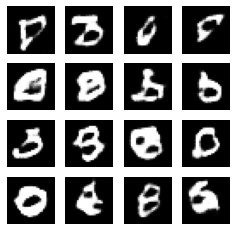

2000 [D 손실 : 0.337800, 정확도 : 87.11%] [G 손실 : 2.640109]


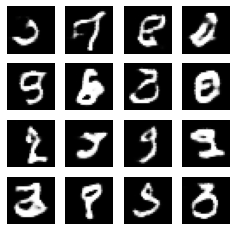

3000 [D 손실 : 0.349435, 정확도 : 83.20%] [G 손실 : 2.130943]


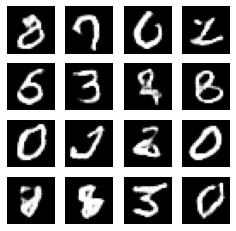

4000 [D 손실 : 0.371387, 정확도 : 84.38%] [G 손실 : 2.152299]


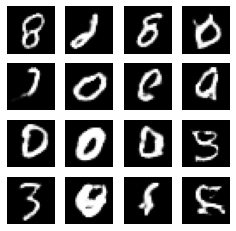

5000 [D 손실 : 0.373936, 정확도 : 84.77%] [G 손실 : 2.073499]


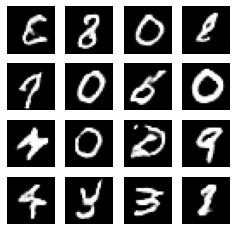

6000 [D 손실 : 0.332343, 정확도 : 84.38%] [G 손실 : 2.023756]


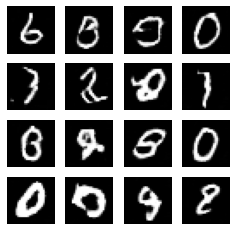

7000 [D 손실 : 0.395900, 정확도 : 82.81%] [G 손실 : 2.277470]


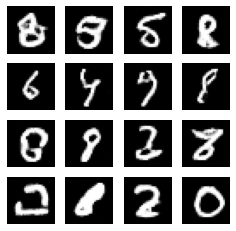

8000 [D 손실 : 0.418830, 정확도 : 80.08%] [G 손실 : 1.916879]


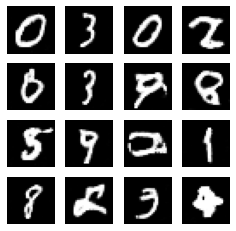

9000 [D 손실 : 0.452533, 정확도 : 77.73%] [G 손실 : 1.713189]


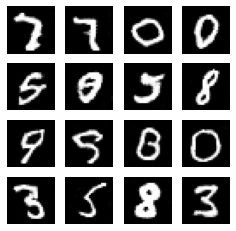

10000 [D 손실 : 0.395938, 정확도 : 82.81%] [G 손실 : 1.968648]


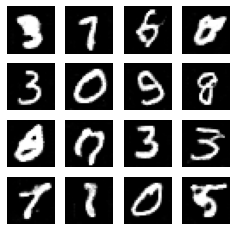

11000 [D 손실 : 0.410329, 정확도 : 78.91%] [G 손실 : 1.758843]


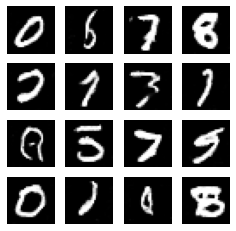

12000 [D 손실 : 0.337657, 정확도 : 84.38%] [G 손실 : 2.468478]


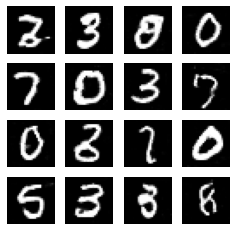

13000 [D 손실 : 0.344929, 정확도 : 84.77%] [G 손실 : 1.951700]


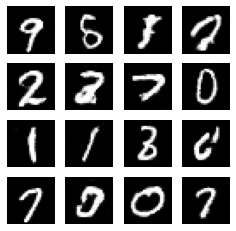

14000 [D 손실 : 0.398772, 정확도 : 82.42%] [G 손실 : 2.157440]


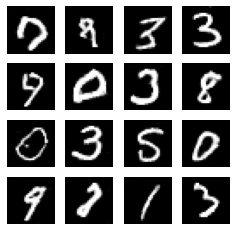

15000 [D 손실 : 0.417312, 정확도 : 77.34%] [G 손실 : 2.114768]


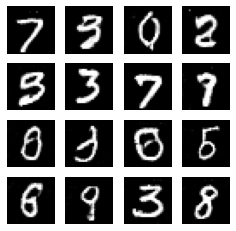

16000 [D 손실 : 0.387656, 정확도 : 83.98%] [G 손실 : 2.395736]


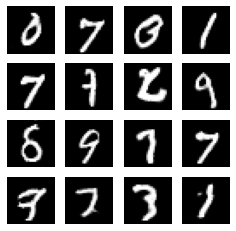

17000 [D 손실 : 0.339886, 정확도 : 83.98%] [G 손실 : 2.107914]


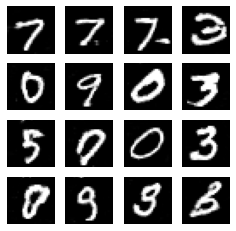

18000 [D 손실 : 0.342145, 정확도 : 86.33%] [G 손실 : 2.507249]


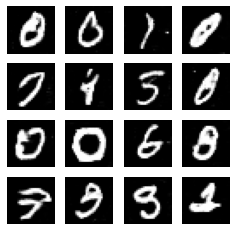

19000 [D 손실 : 0.365370, 정확도 : 83.98%] [G 손실 : 2.561232]


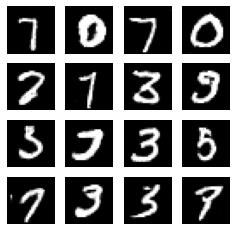

20000 [D 손실 : 0.374724, 정확도 : 83.59%] [G 손실 : 2.261081]


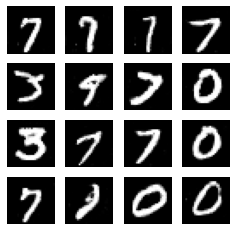

In [ ]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)